In [15]:
# basic imports
import os
import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline 
import seaborn as sns

# disable warnings for libraries
import warnings
warnings.filterwarnings("ignore")

# configure logger
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)

In [21]:
import numpy as np
#Expected rate for each word in the vocabulary
def load_embeddings():
    # Load rates
    logger.info("Loading embedding vectors...")
    rates= np.genfromtxt('/Users/suzie/Downloads/aclImdb/imdbEr.txt')
    logger.info(f"Loaded vectors with shape: {rates.shape}")
    
    # Load associated words
    logger.info("Loading words...")
    with open('/Users/suzie/Downloads/aclImdb/imdb.vocab', 'r', encoding='utf-8') as f:
        words = [line.strip() for line in f.readlines()]
    logger.info(f"Loaded {len(words)} words")
    
    # Verify sizes match
    if len(words) != rates.shape[0]:
        raise ValueError(f"Mismatch between number of words ({len(words)}) and vectors ({rates.shape[0]})")
    
    logger.info("Verification complete - sizes match!")
    
    return rates, words

# Load the data
rates, words = load_embeddings()

# Display some basic information
print("\nDataset information:")
print(f"Number of words: {len(words)}")
print(f"Embedding dimension: {rates.shape}")
print(f"\nFirst few words and their expected rates {[(word, rate) for (word, rate) in zip(words[:5], rates[:5])]}")


06:54:26 INFO:Loading embedding vectors...
06:54:26 INFO:Loaded vectors with shape: (89527,)
06:54:26 INFO:Loading words...
06:54:26 INFO:Loaded 89527 words
06:54:26 INFO:Verification complete - sizes match!



Dataset information:
Number of words: 89527
Embedding dimension: (89527,)

First few words and their expected rates [('the', np.float64(0.0490972013402)), ('and', np.float64(0.201363575849)), ('a', np.float64(0.0333946807184)), ('of', np.float64(0.099837669572)), ('to', np.float64(-0.0790210365788))]


In [41]:
# Filtrer les mots considérés comme stop words selon la condition np.abs(rate) < 0.25
stopwords = [word for word, rate in zip(words, rates) if np.abs(rate) < 0.7]
print(f"Nombre de stop words détectés : {len(stopwords)}")

# Écrire ces stop words dans un fichier
with open("stop_word_rate.txt", "w", encoding="utf-8") as f:
    for word in stopwords:
        f.write(word + "\n")

print("Le fichier stop_word_rate.txt a été créé avec succès.")

Nombre de stop words détectés : 63286
Le fichier stop_word_rate.txt a été créé avec succès.


In [43]:
import os
import pandas as pd

def process_movie_reviews(directory_path):
    """
    Traite les fichiers de critiques de films et les combine dans un DataFrame.
    
    Args:
        directory_path (str): Chemin vers le répertoire contenant les fichiers texte
        
    Returns:
        pd.DataFrame: DataFrame contenant les colonnes id, rate, et comment
    """
    # Listes pour stocker les données
    movie_ids = []
    rates = []
    comments = []
    
    # Parcourir tous les fichiers du répertoire
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            # Extraire l'id et la note du nom du fichier
            parts = filename.split('_')
            if len(parts) == 2:
                movie_id = int(parts[0])
                rate = int(parts[1].split('.')[0])
                
                # Lire le contenu du fichier (commentaire)
                with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as f:
                    comment = f.read().strip()
                
                # Ajouter les données aux listes
                movie_ids.append(movie_id)
                rates.append(rate)
                comments.append(comment)
    
    # Créer le DataFrame
    df = pd.DataFrame({
        'id': movie_ids,
        'rate': rates,
        'comment': comments
    })
    
    # Trier par id de film
    df = df.sort_values('id')
    
    return df

# Exemple d'utilisation
pos_df = process_movie_reviews('/Users/suzie/Downloads/aclImdb/train/pos')
neg_df = process_movie_reviews('/Users/suzie/Downloads/aclImdb/train/neg')
# Ajouter une colonne 'sentiment' pour distinguer les avis positifs et négatifs 
pos_df['sentiment'] = 1
neg_df['sentiment'] = 0
# Concaténer les DataFrames positifs et négatifs
df = pd.concat([pos_df, neg_df], ignore_index=True)
# Mélanger les données
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

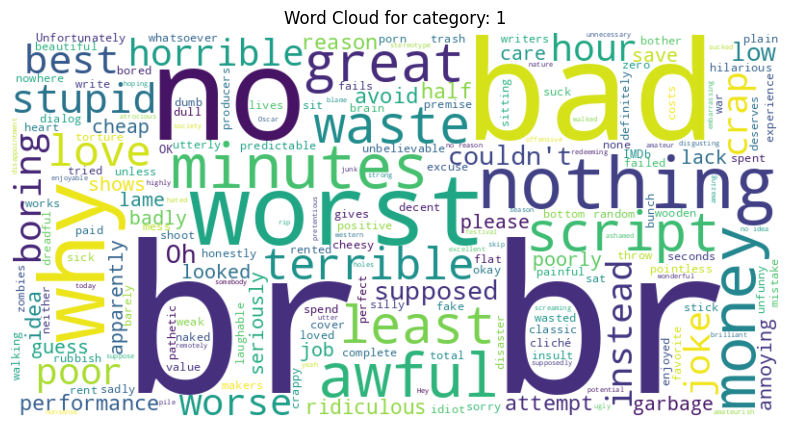

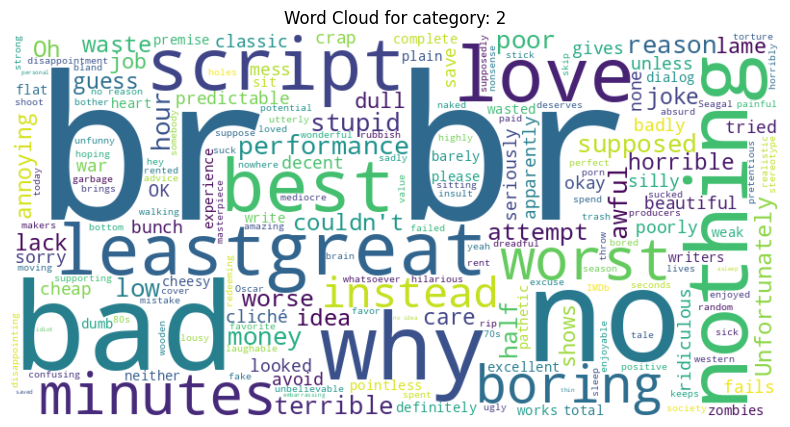

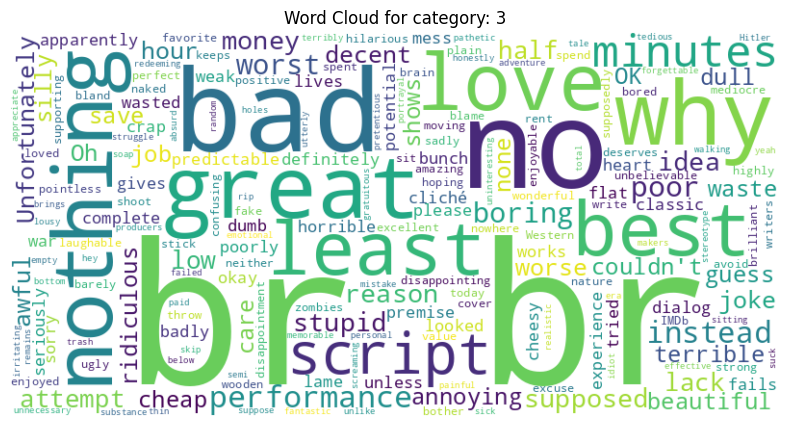

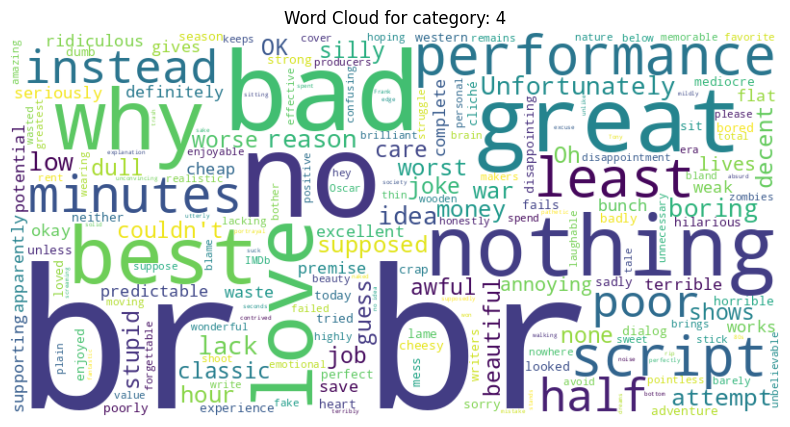

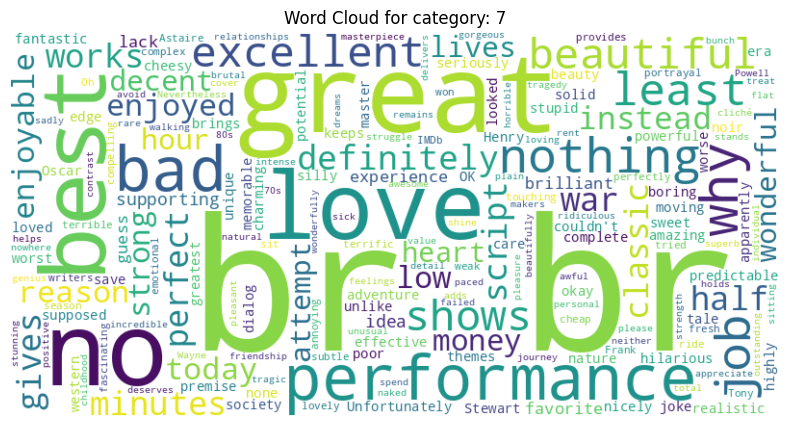

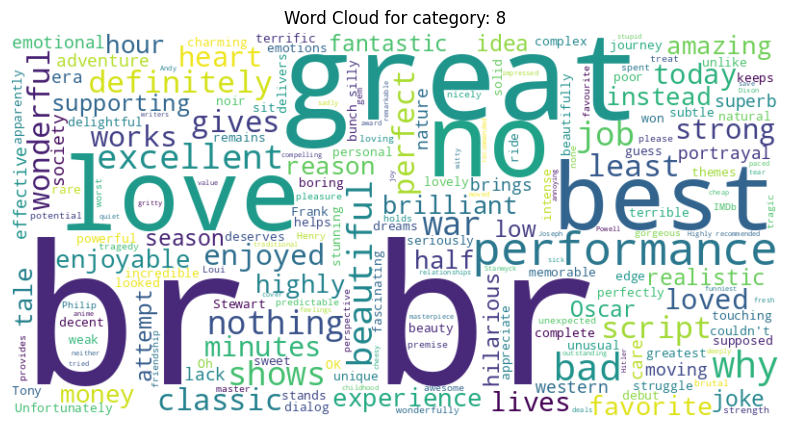

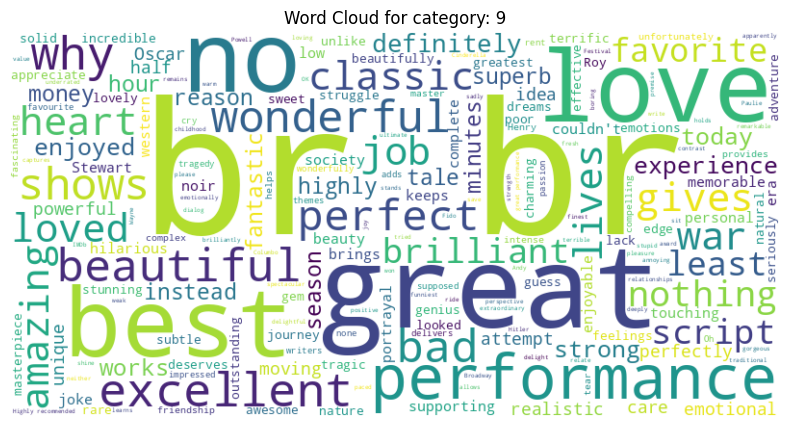

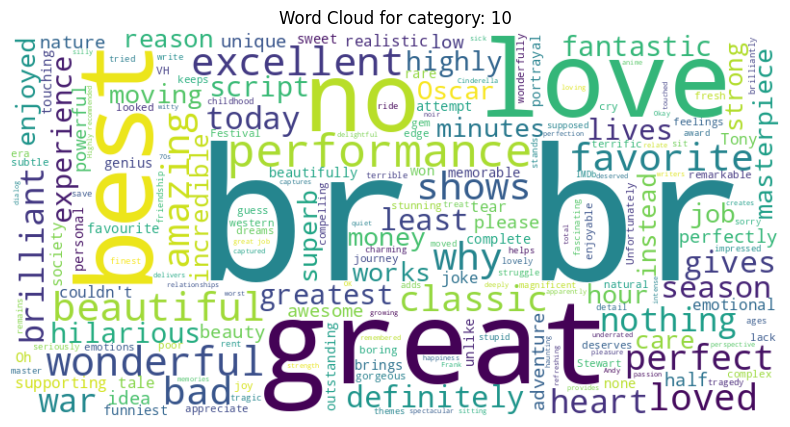

In [44]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes
import matplotlib.pyplot as plt

#we will consider the stopwords as the np.abs(rate)<0.05
STOPWORDS = [x.strip() for x in open('/Users/suzie/Downloads/aclImdb/stop_word_rate.txt').readlines()]
import matplotlib.pyplot as plt

# plot a word cloud for each category
for rate in [1, 2, 3, 4, 7, 8, 9, 10]:
 # Filter the DataFrame for the current category
    df_cat = df[df['rate'] == rate]

    # Combine all articles in the category into one string
    text = " ".join(df_cat['comment'].tolist())

    # Create the word cloud object
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for category: {rate}")
    plt.show()

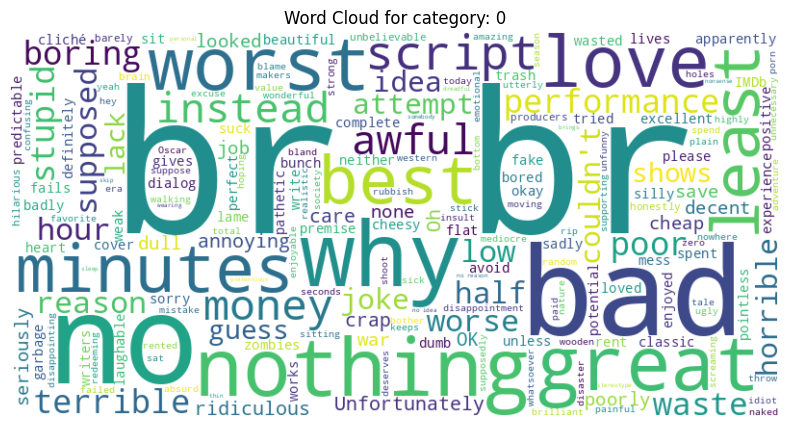

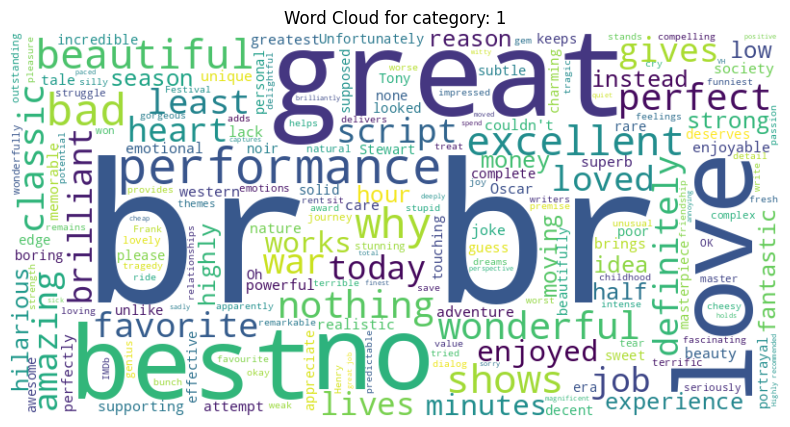

In [45]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes
import matplotlib.pyplot as plt

#we will consider the stopwords as the np.abs(rate)<0.05
STOPWORDS = [x.strip() for x in open('/Users/suzie/Downloads/aclImdb/stop_word_rate.txt').readlines()]
import matplotlib.pyplot as plt

# plot a word cloud for each category
for sentiment in [0, 1]:
 # Filter the DataFrame for the current category
    df_cat = df[df['sentiment'] == sentiment]

    # Combine all articles in the category into one string
    text = " ".join(df_cat['comment'].tolist())

    # Create the word cloud object
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for category: {sentiment}")
    plt.show()

Binary classificaication with Naive Bayes and TF-IDF

In [48]:
from sklearn.model_selection import train_test_split
# Split the dataset, create X (features) and y (target), print the size
X = df['comment']
y = df['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [50]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


# We'll test different configurations
max_features_options = [1000, 2000, 5000]
use_idf_options = [True, False]  # Test with and without IDF
alpha_options = [0.1, 1.0, 10.0]  # Smoothing parameter for Naive Bayes

# Store results
results = []

for max_features in max_features_options:
    for use_idf in use_idf_options:
        for alpha in alpha_options:
            # Create and fit the vectorizer on training data only
            vectorizer = CountVectorizer(max_features=max_features)
            X_train_counts = vectorizer.fit_transform(X_train)
            X_val_counts = vectorizer.transform(X_val)
            
            # Apply TF-IDF transformation
            tfidf = TfidfTransformer(use_idf=use_idf)
            X_train_tfidf = tfidf.fit_transform(X_train_counts)
            X_val_tfidf = tfidf.transform(X_val_counts)
            
            # Train classifier
            clf = MultinomialNB(alpha=alpha)
            clf.fit(X_train_tfidf, y_train)
            
            # Get scores
            train_score = clf.score(X_train_tfidf, y_train)
            val_score = clf.score(X_val_tfidf, y_val)
            
            # Store configuration and results
            config = {
                'max_features': max_features,
                'use_idf': use_idf,
                'alpha': alpha,
                'train_accuracy': train_score,
                'val_accuracy': val_score
            }
            results.append(config)

# Find best configuration based on validation score
best_config = max(results, key=lambda x: x['val_accuracy'])
print("\nBest configuration (based on validation accuracy):")
print("-" * 80)
print(f"Max Features: {best_config['max_features']}")
print(f"Use IDF: {best_config['use_idf']}")
print(f"Alpha: {best_config['alpha']}")
print(f"Train Accuracy: {best_config['train_accuracy']:.4f}")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")


Best configuration (based on validation accuracy):
--------------------------------------------------------------------------------
Max Features: 5000
Use IDF: True
Alpha: 1.0
Train Accuracy: 0.8669
Validation Accuracy: 0.8542


In [47]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 3.4 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
